In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd

In [2]:
df = pd.read_csv('old_accident_dummy_eclo_v9.csv')

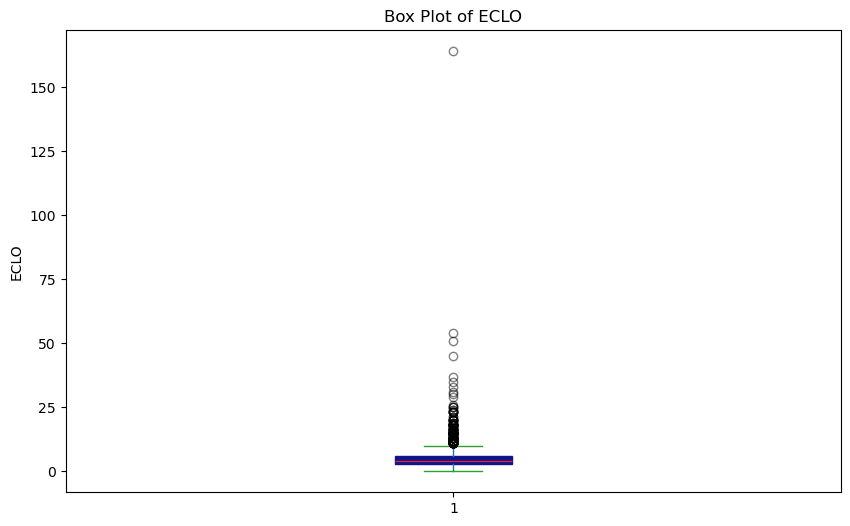

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시 데이터프레임 생성

# 색상 코드 설정
colors = {
    'boxes': '#0f148d',      # 박스 색상
    'whiskers': '#1f77b4',   # 수염 색상
    'caps': '#2ca02c',       # 캡 색상
    'medians': '#d62728',    # 중앙값 색상
    'fliers': '#ff7f0e'      # 이상치 색상
}

# '인명피해 심각도' 열에 대한 박스플랏 시각화
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(df['인명피해 심각도'], patch_artist=True, flierprops=dict(marker='o', color=colors['fliers'], alpha=0.5))

# 색상 코드로 색상 지정
for element in ['boxes', 'whiskers', 'caps', 'medians']:
    plt.setp(boxplot[element], color=colors[element])

# 박스 내부 색상 지정
for patch in boxplot['boxes']:
    patch.set(facecolor=colors['boxes'])

# 그래프 제목 및 축 레이블 설정
plt.title('Box Plot of ECLO')
plt.ylabel('ECLO')
plt.savefig('boxplot_before_removal.png', format='png')
plt.show()



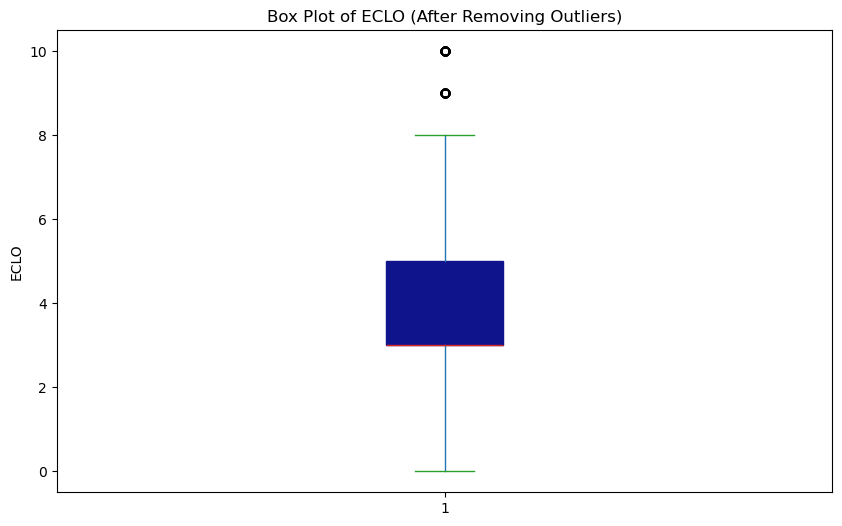

In [4]:
# IQR 계산
Q1 = df['인명피해 심각도'].quantile(0.25)
Q3 = df['인명피해 심각도'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 경계 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
df_cleaned = df[(df['인명피해 심각도'] >= lower_bound) & (df['인명피해 심각도'] <= upper_bound)]

# 이상치 제거 후 박스플랏 시각화
plt.figure(figsize=(10, 6))
boxplot_cleaned = plt.boxplot(df_cleaned['인명피해 심각도'], patch_artist=True, flierprops=dict(marker='o', color=colors['fliers'], alpha=0.5))

# 색상 코드로 색상 지정
for element in ['boxes', 'whiskers', 'caps', 'medians']:
    plt.setp(boxplot_cleaned[element], color=colors[element])

# 박스 내부 색상 지정
for patch in boxplot_cleaned['boxes']:
    patch.set(facecolor=colors['boxes'])

# 그래프 제목 및 축 레이블 설정
plt.title('Box Plot of ECLO (After Removing Outliers)')
plt.ylabel('ECLO')

# 그래프를 PNG 파일로 저장
plt.savefig('boxplot_after_removal.png', format='png')
plt.show()

In [5]:
#df_cleaned

In [6]:
df_cleaned.dtypes


요일           object
법규위반         object
가해운전자차종      object
가해운전자성별      object
가해운전자상해정도    object
              ...  
인명피해 심각도      int64
사망자수          int64
중상자수          int64
경상자수          int64
부상신고자수        int64
Length: 110, dtype: object

In [7]:
df_cleaned.to_csv('df_cleaned.csv')

In [8]:
categorical_columns = [
    '요일', '법규위반', 
    '가해운전자차종', '가해운전자성별', '가해운전자상해정도',
    '피해운전자차종', '피해운전자성별', '피해운전자상해정도',
    'cleanedAdress', '사고대분류', '사고중분류', '사고소분류', 
    '도로형태_대', '도로형태_중','노면상태','기상상태'
    #####기상상태, 노면상태는 왜 빠진거냐묘...
]

In [9]:
for column in categorical_columns:
    df_cleaned[column] = df_cleaned[column].astype('category')

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1047961618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = df_cleaned[column].astype('category')
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1047961618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[column] = df_cleaned[column].astype('category')
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1047961618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [10]:
pd.set_option('display.max_rows', None)

print(df_cleaned.dtypes)

요일                     category
법규위반                   category
가해운전자차종                category
가해운전자성별                category
가해운전자상해정도              category
피해운전자상해정도              category
가해운전자연령                  object
피해운전자차종                category
피해운전자성별                category
피해운전자연령                  object
노면상태                   category
기상상태                   category
cleanedAdress          category
X                       float64
Y                       float64
사고연도                      int64
사고월                       int64
사고일                       int64
사고시각                      int64
사고대분류                  category
사고중분류                  category
사고소분류                  category
도로형태_대                 category
도로형태_중                 category
D.법규위반.과속                 int64
D.법규위반.교차로운행방법위반          int64
D.법규위반.기타                 int64
D.법규위반.보행자보호의무위반          int64
D.법규위반.불법유턴               int64
D.법규위반.신호위반               int64
D.법규위반.안전거리미확보            int64
D.법규위반.중

In [11]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from catboost import CatBoostRegressor
import lightgbm as lgb

In [12]:
# 범주형 변수들 (원핫인코딩 할.)
cat_features = [
    '요일', '법규위반', 
    '가해운전자차종', '가해운전자성별', '가해운전자상해정도', 
    '피해운전자차종', '피해운전자성별', '피해운전자상해정도', 
    'cleanedAdress', '사고대분류', '사고중분류', '사고소분류', 
    '도로형태_대', '도로형태_중','노면상태','기상상태'
]


In [13]:
X = df_cleaned.drop(columns=['인명피해 심각도','사망자수','부상신고자수','경상자수','중상자수']) # 레이블 제거, 독립변수들.
y = df_cleaned['인명피해 심각도'] # 종속변수

X_train_x, X_test_x, X_train_y, X_test_y = train_test_split(X, y, test_size=0.2, random_state=42)
C_train_x, C_test_x, C_train_y, C_test_y = train_test_split(X, y, test_size=0.2, random_state=42)
L_train_x, L_test_x, L_train_y, L_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

# print(f"XGB훈련 데이터 개수:{len(X_train_x)}")
# print(f"XGB테스트 데이터 개수:{len(X_test_x)}")
# print(f"CAT훈련 데이터 개수:{len(X_train_x)}")
# print(f"CAT테스트 데이터 개수:{len(X_test_x)}")
# print(f"LGB훈련 데이터 개수:{len(X_train_x)}")
# print(f"LGB테스트 데이터 개수:{len(X_test_x)}")

## 범주형 변수, 원핫인코딩_문자열 타입 칼럼 적용
train_oh = pd.get_dummies(C_train_x[cat_features])
test_oh = pd.get_dummies(C_test_x[cat_features])

for i in train_oh.columns:
    if i not in test_oh.columns:
        test_oh[i] = 0

test_oh=test_oh[train_oh.columns] # 
display(len(test_oh.columns), len(train_oh.columns))

C_train_x.drop(cat_features, axis=1, inplace=True)
C_test_x.drop(cat_features, axis=1, inplace=True)

C_train_x=pd.concat([C_train_x, train_oh], axis=1)
C_test_x=pd.concat([C_test_x, test_oh], axis=1)

# # DMatrix로 변환
# dtrain_x = xgb.DMatrix(X_train_x, label=y_train_x, enable_categorical=True)
# dtest_x = xgb.DMatrix(X_test_x, label=y_test_x, enable_categorical=True)

# train_data = lgb.Dataset(X_train_l, label=y_train_l)
# test_data = lgb.Dataset(X_test_l, label=y_test_l)
# # dtrain_c = xgb.DMatrix(X_train_x, label=y_train_x, enable_categorical=True)
# # dtest_c = xgb.DMatrix(X_test_x, label=y_test_x, enable_categorical=True)


154

154

In [14]:
## 범주형 변수, 원핫인코딩_칼럼들을 모두 수치형 변수 변환
from sklearn.preprocessing import LabelEncoder

categorical_features = list(C_train_x.dtypes[C_train_x.dtypes == "object"].index)
## objct 객체가 가해자/피해자 연령 변수 정도밖에 없는 거 같긴함
display(categorical_features)

for i in categorical_features:
    print(i)
    le = LabelEncoder()
    le = le.fit(C_train_x[i])
    C_train_x[i] = le.transform(C_train_x[i])

    for case in np.unique(C_test_x[i]):
        if case not in le.classes_:
            print('test case is not in classes')
            le.classes_=np.append(le.classes_, case)
    C_test_x[i] = le.transform(C_test_x[i])

display(C_train_x.head())
display(C_test_x.head())


['가해운전자연령', '피해운전자연령']

가해운전자연령
피해운전자연령
test case is not in classes


,가해운전자연령,피해운전자연령,X,Y,사고연도,사고월,사고일,사고시각,D.법규위반.과속,D.법규위반.교차로운행방법위반,...,노면상태_서리/결빙,노면상태_습기,노면상태_적설,노면상태_젖음/습기,기상상태_기타,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_안개,기상상태_흐림
2818,6,36,127.144382,36.809389,2023,4,18,20,0,0,...,False,False,False,False,False,False,True,False,False,False
2927,2,51,127.123154,36.801086,2023,7,24,14,0,0,...,False,False,False,False,False,False,True,False,False,False
292,0,43,127.124344,36.930865,2011,6,30,12,0,0,...,False,False,False,False,False,False,True,False,False,False
1511,3,71,127.151968,36.799544,2019,4,10,10,0,0,...,False,False,False,False,False,False,True,False,False,False
2524,20,0,127.086917,36.671026,2022,10,12,10,0,0,...,False,False,False,False,False,False,True,False,False,False


,가해운전자연령,피해운전자연령,X,Y,사고연도,사고월,사고일,사고시각,D.법규위반.과속,D.법규위반.교차로운행방법위반,...,노면상태_서리/결빙,노면상태_습기,노면상태_적설,노면상태_젖음/습기,기상상태_기타,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_안개,기상상태_흐림
870,20,21,127.170560,36.797062,2016,4,19,11,0,0,...,False,False,False,False,False,False,True,False,False,False
278,4,27,127.123154,36.801086,2011,4,11,9,0,0,...,False,False,False,False,False,False,True,False,False,False
2687,0,19,127.123154,36.801086,2023,3,20,19,0,0,...,False,False,False,False,False,False,True,False,False,False
2670,4,43,127.128066,36.779291,2023,4,26,14,0,1,...,False,False,False,False,False,False,True,False,False,False
2343,14,52,127.191434,36.876896,2022,3,3,7,0,0,...,False,False,False,False,False,False,True,False,False,False


In [15]:
C_train_x.columns

Index(['가해운전자연령', '피해운전자연령', 'X', 'Y', '사고연도', '사고월', '사고일', '사고시각',
       'D.법규위반.과속', 'D.법규위반.교차로운행방법위반',
       ...
       '노면상태_서리/결빙', '노면상태_습기', '노면상태_적설', '노면상태_젖음/습기', '기상상태_기타', '기상상태_눈',
       '기상상태_맑음', '기상상태_비', '기상상태_안개', '기상상태_흐림'],
      dtype='object', length=243)

In [16]:
# Model Train & Prediction
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping
from catboost import CatBoostRegressor
import optuna

from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import train_test_split

In [17]:
# # model optuna definitions
# def xgb_modeling(X_train, y_train, X_valid, y_valid):
#   def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
#         'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1.0),
#         'max_depth': trial.suggest_int('max_depth', 3, 15),
#         'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
#         'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
#     }

#     model = XGBRegressor(**params, random_state=42, n_jobs=-1, objective='reg:squaredlogerror')
#     bst_xgb = model.fit(X_train,y_train, eval_set = [(X_valid,y_valid)], eval_metric='rmsle', early_stopping_rounds=100,verbose=False)

#     preds = bst_xgb.predict(X_valid)
#     if (preds<0).sum()>0:
#       print('negative')
#       preds = np.where(preds>0,preds,0)
#     loss = msle(y_valid,preds)

#     return np.sqrt(loss)

#   study_xgb = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=100))
#   study_xgb.optimize(objective,n_trials=30,show_progress_bar=True)

#   xgb_reg = XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1, objective='reg:squaredlogerror')
#   xgb_reg.fit(X_train,y_train,eval_set = [(X_valid,y_valid)], eval_metric='rmsle', early_stopping_rounds=100,verbose=False)

#   return xgb_reg,study_xgb

# def lgbm_modeling(X_train, y_train, X_valid, y_valid):
#   def objective(trial):
#     param = {
#         'objective': 'regression',
#         'verbose': -1,
#         'metric': 'rmse',
#         'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
#         'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
#         'max_depth': trial.suggest_int('max_depth',3, 15),
#         'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
#     }

#     model = LGBMRegressor(**param, random_state=42, n_jobs=-1)
#     bst_lgbm = model.fit(X_train,y_train, eval_set = [(X_valid,y_valid)], eval_metric='rmse',callbacks=[early_stopping(stopping_rounds=100)])

#     preds = bst_lgbm.predict(X_valid)
#     if (preds<0).sum()>0:
#       print('negative')
#       preds = np.where(preds>0,preds,0)
#     loss = msle(y_valid,preds)

#     return np.sqrt(loss)

#   study_lgbm = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=100))
#   study_lgbm.optimize(objective,n_trials=30,show_progress_bar=True)

#   lgbm_reg = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)
#   lgbm_reg.fit(X_train,y_train,eval_set = [(X_valid,y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

#   return lgbm_reg,study_lgbm


# def cat_modeling(X_train, y_train, X_valid, y_valid):
#   def objective(trial):
#     param = {
#         'iterations':trial.suggest_int("iterations", 1000, 20000),
#         'od_wait':trial.suggest_int('od_wait', 500, 2300),
#         'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
#         'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
#         'subsample': trial.suggest_uniform('subsample',0,1),
#         'random_strength': trial.suggest_uniform('random_strength',10,50),
#         'depth': trial.suggest_int('depth',1, 15),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
#         'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
#         'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
#     }


#     model = CatBoostRegressor(**param, random_state=42)
#     #task_type="GPU",devices='0:1'
#     bst_cat = model.fit(X_train,y_train, eval_set = [(X_valid,y_valid)], early_stopping_rounds=100,verbose=False)

#     preds = bst_cat.predict(X_valid)
#     if (preds<0).sum()>0:
#       print('negative')
#       preds = np.where(preds>0,preds,0)
#     loss = msle(y_valid,preds)

#     return np.sqrt(loss)

#   study_cat = optuna.create_study(direction='minimize',sampler=optuna.samplers.TPESampler(seed=100))
#   study_cat.optimize(objective,n_trials=30,show_progress_bar=True)

#   cat_reg = CatBoostRegressor(**study_cat.best_params, random_state=42)
#   cat_reg.fit(X_train,y_train,eval_set = [(X_valid,y_valid)], early_stopping_rounds=100,verbose=False)

#   return cat_reg,study_cat

In [18]:
# XGBoost
def xgb_modeling(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1.0),  # 최소값이 0보다 큼
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1.0),  # 최소값이 0보다 큼
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    model = XGBRegressor(**params, random_state=42, n_jobs=-1, objective='reg:squaredlogerror')
    bst_xgb = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmsle', early_stopping_rounds=100, verbose=False)

    preds = bst_xgb.predict(X_valid)
    preds = np.maximum(preds, 0)  # negative value 방지
    loss = msle(y_valid, preds)

    return np.sqrt(loss)

  study_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
  study_xgb.optimize(objective, n_trials=30, show_progress_bar=True)

  xgb_reg = XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1, objective='reg:squaredlogerror')
  xgb_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmsle', early_stopping_rounds=100, verbose=False)

  return xgb_reg, study_xgb

# LightGBM
def lgbm_modeling(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 10.0),  # 최소값이 0보다 큼
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1e-2),  # 최소값이 0보다 큼
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
    }

    model = LGBMRegressor(**param, random_state=42, n_jobs=-1)
    bst_lgbm = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

    preds = bst_lgbm.predict(X_valid)
    preds = np.maximum(preds, 0)
    loss = msle(y_valid, preds)

    return np.sqrt(loss)

  study_lgbm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
  study_lgbm.optimize(objective, n_trials=30, show_progress_bar=True)

  lgbm_reg = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)
  lgbm_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

  return lgbm_reg, study_lgbm

# CatBoost
def cat_modeling(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'iterations': trial.suggest_int("iterations", 1000, 20000),
        'od_wait': trial.suggest_int('od_wait', 500, 2300),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'depth': trial.suggest_int('depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),  # 최소값이 0보다 큼
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.4, 1.0),
    }

    model = CatBoostRegressor(**param, random_state=42, silent=True)
    bst_cat = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    preds = bst_cat.predict(X_valid)
    preds = np.maximum(preds, 0)
    loss = msle(y_valid, preds)

    return np.sqrt(loss)

  study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
  study_cat.optimize(objective, n_trials=30, show_progress_bar=True)

  cat_reg = CatBoostRegressor(**study_cat.best_params, random_state=42)
  cat_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

  return cat_reg, study_cat

In [19]:
# Ensamble
X_train,X_valid,y_train,y_valid = train_test_split(C_train_x,C_train_y,random_state=42,shuffle=True,test_size=0.2)

### 타겟변수 왜도 첨도 조정>>log 처리
temp_train_y = np.log1p(y_train)
temp_valid_y = np.log1p(y_valid)

cat,study_cat = cat_modeling(X_train,temp_train_y,X_valid,temp_valid_y)
xgb,study_xgb = xgb_modeling(X_train,temp_train_y,X_valid,temp_valid_y)
lgbm,study_lgbm = lgbm_modeling(X_train,temp_train_y,X_valid,temp_valid_y)

cat_prediction = cat.predict(C_test_x)
xgb_prediction = xgb.predict(C_test_x)
lgbm_prediction = lgbm.predict(C_test_x)

cat_prediction = np.expm1(cat_prediction)
xgb_prediction = np.expm1(xgb_prediction)
lgbm_prediction = np.expm1(lgbm_prediction)


[I 2024-08-17 01:37:36,819] A new study created in memory with name: no-name-c20a47b3-4524-47e4-8132-00ce20066b6d


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:37:38,149] Trial 0 finished with value: 0.13542209330319444 and parameters: {'iterations': 11325, 'od_wait': 1001, 'learning_rate': 0.43027241484164175, 'reg_lambda': 8.192810811467792, 'subsample': 0.5023594280954863, 'depth': 4, 'min_data_in_leaf': 21, 'bagging_temperature': 20.10995137164808, 'colsample_bylevel': 0.4820239538109718}. Best is trial 0 with value: 0.13542209330319444.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:37:39,492] Trial 1 finished with value: 0.13507475187525889 and parameters: {'iterations': 11927, 'od_wait': 2105, 'learning_rate': 0.2171101008960177, 'reg_lambda': 0.00019828850428696838, 'subsample': 0.5541884452321275, 'depth': 5, 'min_data_in_leaf': 30, 'bagging_temperature': 17.649507712055232, 'colsample_bylevel': 0.5031646076395565}. Best is trial 1 with value: 0.13507475187525889.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:37:41,618] Trial 2 finished with value: 0.12917046117539221 and parameters: {'iterations': 16509, 'od_wait': 993, 'learning_rate': 0.43738714182649047, 'reg_lambda': 38.03721727718406, 'subsample': 0.9088246893883637, 'depth': 7, 'min_data_in_leaf': 6, 'bagging_temperature': 0.3099760823845949, 'colsample_bylevel': 0.4034131044115441}. Best is trial 2 with value: 0.12917046117539221.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:37:45,274] Trial 3 finished with value: 0.1289131731931125 and parameters: {'iterations': 5796, 'od_wait': 1932, 'learning_rate': 0.02510242153387562, 'reg_lambda': 0.15556204313856575, 'subsample': 0.8019022695214268, 'depth': 4, 'min_data_in_leaf': 12, 'bagging_temperature': 0.013992787099041113, 'colsample_bylevel': 0.9342469380652454}. Best is trial 3 with value: 0.1289131731931125.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:37:53,429] Trial 4 finished with value: 0.15470676583785803 and parameters: {'iterations': 19638, 'od_wait': 607, 'learning_rate': 0.8916404852812191, 'reg_lambda': 0.10922209330861626, 'subsample': 0.8712398445489886, 'depth': 11, 'min_data_in_leaf': 18, 'bagging_temperature': 0.012071369066215953, 'colsample_bylevel': 0.5260159466037164}. Best is trial 3 with value: 0.1289131731931125.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:39:44,468] Trial 5 finished with value: 0.1627732243970535 and parameters: {'iterations': 11349, 'od_wait': 1885, 'learning_rate': 0.25818827684701195, 'reg_lambda': 0.0010029281769460263, 'subsample': 0.9261975439206531, 'depth': 15, 'min_data_in_leaf': 27, 'bagging_temperature': 0.2741772245010004, 'colsample_bylevel': 0.7593153675254483}. Best is trial 3 with value: 0.1289131731931125.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:39:48,130] Trial 6 finished with value: 0.14727192776845768 and parameters: {'iterations': 7741, 'od_wait': 1112, 'learning_rate': 0.18630017961074682, 'reg_lambda': 0.00046116831428735127, 'subsample': 0.5224311412303877, 'depth': 9, 'min_data_in_leaf': 12, 'bagging_temperature': 2.350832054761842, 'colsample_bylevel': 0.7779651253524984}. Best is trial 3 with value: 0.1289131731931125.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:39:49,465] Trial 7 finished with value: 0.14050233877022125 and parameters: {'iterations': 3709, 'od_wait': 2181, 'learning_rate': 0.9469160820010103, 'reg_lambda': 0.16446617954069917, 'subsample': 0.6938831401633154, 'depth': 7, 'min_data_in_leaf': 7, 'bagging_temperature': 0.12795587929930752, 'colsample_bylevel': 0.5479215287221297}. Best is trial 3 with value: 0.1289131731931125.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:39:50,971] Trial 8 finished with value: 0.12331621563440959 and parameters: {'iterations': 4298, 'od_wait': 2240, 'learning_rate': 0.9574424743492701, 'reg_lambda': 0.15339661999836005, 'subsample': 0.8656503765299612, 'depth': 7, 'min_data_in_leaf': 3, 'bagging_temperature': 0.7144832893064522, 'colsample_bylevel': 0.7052193359429164}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:15,497] Trial 9 finished with value: 0.16675994707114405 and parameters: {'iterations': 2680, 'od_wait': 1450, 'learning_rate': 0.992236456145423, 'reg_lambda': 0.005824404413742965, 'subsample': 0.6677982208592841, 'depth': 13, 'min_data_in_leaf': 23, 'bagging_temperature': 0.17875811498616243, 'colsample_bylevel': 0.7804220097773651}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:18,511] Trial 10 finished with value: 0.132119283641687 and parameters: {'iterations': 1071, 'od_wait': 1593, 'learning_rate': 0.7118163754631442, 'reg_lambda': 3.842216674899705, 'subsample': 0.995415428975727, 'depth': 9, 'min_data_in_leaf': 2, 'bagging_temperature': 3.299042787836781, 'colsample_bylevel': 0.6507868399614823}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:23,257] Trial 11 finished with value: 0.1280226374250995 and parameters: {'iterations': 6825, 'od_wait': 1829, 'learning_rate': 0.019533740508715702, 'reg_lambda': 0.6492894266908911, 'subsample': 0.801141640214416, 'depth': 3, 'min_data_in_leaf': 11, 'bagging_temperature': 0.012290976844940835, 'colsample_bylevel': 0.9281632010414355}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:24,129] Trial 12 finished with value: 0.13080448841280193 and parameters: {'iterations': 7482, 'od_wait': 2292, 'learning_rate': 0.6161524480208268, 'reg_lambda': 1.159433142685527, 'subsample': 0.7929988929073771, 'depth': 3, 'min_data_in_leaf': 2, 'bagging_temperature': 0.048980284068209666, 'colsample_bylevel': 0.9290567430545421}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:25,335] Trial 13 finished with value: 0.13764887282866017 and parameters: {'iterations': 5809, 'od_wait': 1740, 'learning_rate': 0.7516400962046068, 'reg_lambda': 0.01239917315886684, 'subsample': 0.8258006888696977, 'depth': 6, 'min_data_in_leaf': 9, 'bagging_temperature': 1.295817891497688, 'colsample_bylevel': 0.9731807858963896}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:33,361] Trial 14 finished with value: 0.17389634701558201 and parameters: {'iterations': 8228, 'od_wait': 2025, 'learning_rate': 0.5656946677325339, 'reg_lambda': 3.141598700817723e-05, 'subsample': 0.7310483336347247, 'depth': 11, 'min_data_in_leaf': 13, 'bagging_temperature': 98.49383054254461, 'colsample_bylevel': 0.8565460159749012}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:38,704] Trial 15 finished with value: 0.12743234497257172 and parameters: {'iterations': 4362, 'od_wait': 1834, 'learning_rate': 0.028604200931313495, 'reg_lambda': 0.8770135502843786, 'subsample': 0.6445335653976543, 'depth': 3, 'min_data_in_leaf': 4, 'bagging_temperature': 0.03944117768421934, 'colsample_bylevel': 0.6339725223960702}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:40,689] Trial 16 finished with value: 0.13346533812459652 and parameters: {'iterations': 3544, 'od_wait': 1627, 'learning_rate': 0.7781139052265176, 'reg_lambda': 36.06429600445932, 'subsample': 0.5979519854441745, 'depth': 7, 'min_data_in_leaf': 5, 'bagging_temperature': 0.0517835137733336, 'colsample_bylevel': 0.6394936646403795}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:42,035] Trial 17 finished with value: 0.12773907364494297 and parameters: {'iterations': 13610, 'od_wait': 2298, 'learning_rate': 0.39751562405996815, 'reg_lambda': 0.03350819657923586, 'subsample': 0.623166394869573, 'depth': 5, 'min_data_in_leaf': 1, 'bagging_temperature': 6.900014113299285, 'colsample_bylevel': 0.6219959883187127}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:47,930] Trial 18 finished with value: 0.13293559647954775 and parameters: {'iterations': 9412, 'od_wait': 1205, 'learning_rate': 0.310041135067217, 'reg_lambda': 1.66786438257937, 'subsample': 0.7390221690688017, 'depth': 10, 'min_data_in_leaf': 5, 'bagging_temperature': 0.819720575249519, 'colsample_bylevel': 0.7079542785835812}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:51,254] Trial 19 finished with value: 0.12572545467040308 and parameters: {'iterations': 1811, 'od_wait': 1350, 'learning_rate': 0.13440532911965403, 'reg_lambda': 0.0032259510738138113, 'subsample': 0.9960980184421601, 'depth': 8, 'min_data_in_leaf': 16, 'bagging_temperature': 0.05312626530429756, 'colsample_bylevel': 0.5911391626140611}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:53,490] Trial 20 finished with value: 0.15021133426441483 and parameters: {'iterations': 1255, 'od_wait': 676, 'learning_rate': 0.8403918210402045, 'reg_lambda': 0.0035066878869783784, 'subsample': 0.9940123384713315, 'depth': 8, 'min_data_in_leaf': 18, 'bagging_temperature': 0.5310980787731191, 'colsample_bylevel': 0.5683978646209995}. Best is trial 8 with value: 0.12331621563440959.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:40:56,805] Trial 21 finished with value: 0.12329122398968714 and parameters: {'iterations': 4760, 'od_wait': 1291, 'learning_rate': 0.1132660821896376, 'reg_lambda': 0.0827944059850521, 'subsample': 0.9382188474524636, 'depth': 6, 'min_data_in_leaf': 15, 'bagging_temperature': 0.057084287268016905, 'colsample_bylevel': 0.7170991387339196}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:00,144] Trial 22 finished with value: 0.1296345857330461 and parameters: {'iterations': 4910, 'od_wait': 1369, 'learning_rate': 0.12449010937067792, 'reg_lambda': 0.0338465506233923, 'subsample': 0.9379270233342252, 'depth': 8, 'min_data_in_leaf': 16, 'bagging_temperature': 0.11186683936836012, 'colsample_bylevel': 0.7204779873895653}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:02,498] Trial 23 finished with value: 0.12397474932961239 and parameters: {'iterations': 2399, 'od_wait': 1308, 'learning_rate': 0.14442366500799006, 'reg_lambda': 0.0018088201629323313, 'subsample': 0.8699994067375887, 'depth': 6, 'min_data_in_leaf': 22, 'bagging_temperature': 0.03105730126584826, 'colsample_bylevel': 0.8516284823549011}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:04,200] Trial 24 finished with value: 0.12913071751690744 and parameters: {'iterations': 2632, 'od_wait': 885, 'learning_rate': 0.28788442767223077, 'reg_lambda': 3.457338995727082e-05, 'subsample': 0.873990417275652, 'depth': 6, 'min_data_in_leaf': 25, 'bagging_temperature': 0.09119634734693605, 'colsample_bylevel': 0.8716580858506289}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:05,948] Trial 25 finished with value: 0.12993080181665503 and parameters: {'iterations': 5631, 'od_wait': 1514, 'learning_rate': 0.33991972023916417, 'reg_lambda': 0.0875135213402623, 'subsample': 0.8590133763724703, 'depth': 6, 'min_data_in_leaf': 21, 'bagging_temperature': 0.526974511491196, 'colsample_bylevel': 0.8310600329997397}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:07,080] Trial 26 finished with value: 0.12687203329241328 and parameters: {'iterations': 9142, 'od_wait': 1162, 'learning_rate': 0.5298826856175987, 'reg_lambda': 0.0012068962297549597, 'subsample': 0.9387226130004966, 'depth': 5, 'min_data_in_leaf': 29, 'bagging_temperature': 0.026646304389461382, 'colsample_bylevel': 0.6806183836725782}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:09,387] Trial 27 finished with value: 0.12890575804752902 and parameters: {'iterations': 2887, 'od_wait': 1316, 'learning_rate': 0.13574176921862197, 'reg_lambda': 0.020959893506838963, 'subsample': 0.9013598573421999, 'depth': 6, 'min_data_in_leaf': 21, 'bagging_temperature': 0.26725217310383353, 'colsample_bylevel': 0.828116393036151}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:11,085] Trial 28 finished with value: 0.1304500013754287 and parameters: {'iterations': 13545, 'od_wait': 1244, 'learning_rate': 0.6695277484470734, 'reg_lambda': 0.00018336694483287095, 'subsample': 0.8345514854925564, 'depth': 7, 'min_data_in_leaf': 9, 'bagging_temperature': 0.025858555187957027, 'colsample_bylevel': 0.7419575031629277}. Best is trial 21 with value: 0.12329122398968714.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:73: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:75: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5,

[I 2024-08-17 01:41:12,465] Trial 29 finished with value: 0.12778242979393975 and parameters: {'iterations': 4142, 'od_wait': 913, 'learning_rate': 0.433574695912862, 'reg_lambda': 13.361041744887322, 'subsample': 0.9498923887932462, 'depth': 4, 'min_data_in_leaf': 24, 'bagging_temperature': 9.489930477428619, 'colsample_bylevel': 0.8037776126972349}. Best is trial 21 with value: 0.12329122398968714.


[I 2024-08-17 01:41:15,338] A new study created in memory with name: no-name-c767bcab-19fe-47e7-a7fc-927c30e510a3


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:41:34,087] Trial 0 finished with value: 0.15745540666166843 and parameters: {'learning_rate': 0.004267905801362681, 'min_child_weight': 6, 'gamma': 0.07063747742309208, 'reg_alpha': 0.4892741426916107, 'reg_lambda': 0.010219689767013377, 'max_depth': 4, 'n_estimators': 770, 'subsample': 0.9129263775525238, 'colsample_bytree': 0.5683532948424765}. Best is trial 0 with value: 0.15745540666166843.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:41:59,110] Trial 1 finished with value: 0.1795311536670145 and parameters: {'learning_rate': 0.005312268141071225, 'min_child_weight': 18, 'gamma': 0.02620621165181003, 'reg_alpha': 0.02347774812542223, 'reg_lambda': 0.016472282465672096, 'max_depth': 5, 'n_estimators': 986, 'subsample': 0.9058415745446616, 'colsample_bytree': 0.5859705063662971}. Best is trial 0 with value: 0.15745540666166843.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:42:10,276] Trial 2 finished with value: 0.14406797815187108 and parameters: {'learning_rate': 0.02809792482174603, 'min_child_weight': 6, 'gamma': 0.07301437421107514, 'reg_alpha': 0.7586817534197297, 'reg_lambda': 0.4318160272658745, 'max_depth': 7, 'n_estimators': 422, 'subsample': 0.6864160231449616, 'colsample_bytree': 0.5028442536762867}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:42:24,735] Trial 3 finished with value: 0.4817554148058053 and parameters: {'learning_rate': 0.000571845964082035, 'min_child_weight': 16, 'gamma': 0.010727782071330188, 'reg_alpha': 0.15764737869807324, 'reg_lambda': 0.16129060764983036, 'max_depth': 4, 'n_estimators': 567, 'subsample': 0.5182380282962844, 'colsample_bytree': 0.9452057817210379}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:42:41,196] Trial 4 finished with value: 0.14419598432239603 and parameters: {'learning_rate': 0.08765214954875089, 'min_child_weight': 2, 'gamma': 0.6040764283363216, 'reg_alpha': 0.14249610675000812, 'reg_lambda': 0.30546353840421125, 'max_depth': 11, 'n_estimators': 707, 'subsample': 0.5102195660134616, 'colsample_bytree': 0.6050132888364304}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:43:09,333] Trial 5 finished with value: 0.1853522363080034 and parameters: {'learning_rate': 0.004305807744337715, 'min_child_weight': 16, 'gamma': 0.03172418386555828, 'reg_alpha': 0.037307090512692404, 'reg_lambda': 0.5067458207848258, 'max_depth': 15, 'n_estimators': 920, 'subsample': 0.6797539219684512, 'colsample_bytree': 0.7994294729378736}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:43:24,813] Trial 6 finished with value: 0.3848055393095407 and parameters: {'learning_rate': 0.0011598099626449496, 'min_child_weight': 7, 'gamma': 0.022707116023127485, 'reg_alpha': 0.029880538312977187, 'reg_lambda': 0.012294887660970706, 'max_depth': 9, 'n_estimators': 563, 'subsample': 0.7964027004879433, 'colsample_bytree': 0.8149709377937486}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:43:34,698] Trial 7 finished with value: 0.5382355556869599 and parameters: {'learning_rate': 0.00026779406230563544, 'min_child_weight': 19, 'gamma': 0.7811955516353158, 'reg_alpha': 0.16017447731321455, 'reg_lambda': 0.05963930319352302, 'max_depth': 7, 'n_estimators': 443, 'subsample': 0.6383825306981676, 'colsample_bytree': 0.6232679406017748}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:43:43,303] Trial 8 finished with value: 0.5373096976180146 and parameters: {'learning_rate': 0.00033175998691021305, 'min_child_weight': 20, 'gamma': 0.8203991480605437, 'reg_alpha': 0.15701725065112326, 'reg_lambda': 0.29013592439301705, 'max_depth': 7, 'n_estimators': 364, 'subsample': 0.7317490094685739, 'colsample_bytree': 0.754349446619097}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:44:04,648] Trial 9 finished with value: 0.5251058008443736 and parameters: {'learning_rate': 0.00018423855510642354, 'min_child_weight': 11, 'gamma': 0.9645307392736476, 'reg_alpha': 0.06166970394263132, 'reg_lambda': 0.046902164272377596, 'max_depth': 13, 'n_estimators': 828, 'subsample': 0.6565332207942549, 'colsample_bytree': 0.8170183414811376}. Best is trial 2 with value: 0.14406797815187108.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:44:12,959] Trial 10 finished with value: 0.14271993842295766 and parameters: {'learning_rate': 0.04115541061699165, 'min_child_weight': 2, 'gamma': 0.2617043006239889, 'reg_alpha': 0.9440163922479855, 'reg_lambda': 0.9683324170407005, 'max_depth': 9, 'n_estimators': 327, 'subsample': 0.8436093776203306, 'colsample_bytree': 0.5075022653200447}. Best is trial 10 with value: 0.14271993842295766.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:44:21,091] Trial 11 finished with value: 0.13865104637546702 and parameters: {'learning_rate': 0.04583306685215533, 'min_child_weight': 1, 'gamma': 0.18836531242431057, 'reg_alpha': 0.9041604650287377, 'reg_lambda': 0.9931848970145725, 'max_depth': 9, 'n_estimators': 321, 'subsample': 0.824132393007576, 'colsample_bytree': 0.5001274901022863}. Best is trial 11 with value: 0.13865104637546702.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:44:29,283] Trial 12 finished with value: 0.1376821074543569 and parameters: {'learning_rate': 0.025767420845856582, 'min_child_weight': 1, 'gamma': 0.2598039625539261, 'reg_alpha': 0.418115971155996, 'reg_lambda': 0.9764261481988681, 'max_depth': 10, 'n_estimators': 311, 'subsample': 0.8409255229048638, 'colsample_bytree': 0.5078493985651129}. Best is trial 12 with value: 0.1376821074543569.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:44:37,805] Trial 13 finished with value: 0.13588308889351652 and parameters: {'learning_rate': 0.01573039632646879, 'min_child_weight': 1, 'gamma': 0.2133481628802214, 'reg_alpha': 0.3525271440433231, 'reg_lambda': 0.7336370108699243, 'max_depth': 11, 'n_estimators': 306, 'subsample': 0.8310050547215366, 'colsample_bytree': 0.6808919978332907}. Best is trial 13 with value: 0.13588308889351652.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:44:51,025] Trial 14 finished with value: 0.14818400091771838 and parameters: {'learning_rate': 0.012303601460157512, 'min_child_weight': 10, 'gamma': 0.24011547530354546, 'reg_alpha': 0.35189396101676407, 'reg_lambda': 0.14424501910418816, 'max_depth': 12, 'n_estimators': 521, 'subsample': 0.9991761285009801, 'colsample_bytree': 0.6790290136067116}. Best is trial 13 with value: 0.13588308889351652.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:45:04,490] Trial 15 finished with value: 0.13501824281364005 and parameters: {'learning_rate': 0.013387738812524773, 'min_child_weight': 4, 'gamma': 0.1348778182370151, 'reg_alpha': 0.3314291464872922, 'reg_lambda': 0.5628913083913993, 'max_depth': 11, 'n_estimators': 462, 'subsample': 0.9069447661351109, 'colsample_bytree': 0.9039292406955277}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:45:18,557] Trial 16 finished with value: 0.137516509635053 and parameters: {'learning_rate': 0.00983047727493076, 'min_child_weight': 5, 'gamma': 0.14670795010359233, 'reg_alpha': 0.2693052301606666, 'reg_lambda': 0.5426380137385813, 'max_depth': 14, 'n_estimators': 482, 'subsample': 0.9994550589213261, 'colsample_bytree': 0.9752348777089842}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:45:35,777] Trial 17 finished with value: 0.3180795801905201 and parameters: {'learning_rate': 0.0015602800919355942, 'min_child_weight': 4, 'gamma': 0.42724693114796936, 'reg_alpha': 0.01361071599855585, 'reg_lambda': 0.20092195616003622, 'max_depth': 12, 'n_estimators': 626, 'subsample': 0.9192835842739916, 'colsample_bytree': 0.6849966569322605}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:45:46,695] Trial 18 finished with value: 0.1462200853215308 and parameters: {'learning_rate': 0.010936492848667092, 'min_child_weight': 9, 'gamma': 0.12293443946406808, 'reg_alpha': 0.2561799407493089, 'reg_lambda': 0.07318368430776073, 'max_depth': 11, 'n_estimators': 400, 'subsample': 0.7604528596799809, 'colsample_bytree': 0.9025618901302269}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:46:03,049] Trial 19 finished with value: 0.3330989225237647 and parameters: {'learning_rate': 0.0014279641560953058, 'min_child_weight': 13, 'gamma': 0.08131130568011391, 'reg_alpha': 0.07431131825341496, 'reg_lambda': 0.032081309452570705, 'max_depth': 15, 'n_estimators': 639, 'subsample': 0.9498168897140331, 'colsample_bytree': 0.8843862583357263}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:46:15,960] Trial 20 finished with value: 0.13570335801727715 and parameters: {'learning_rate': 0.01772694557608966, 'min_child_weight': 4, 'gamma': 0.04885536316609062, 'reg_alpha': 0.5910456060114024, 'reg_lambda': 0.5854348351319166, 'max_depth': 13, 'n_estimators': 465, 'subsample': 0.8815785736291943, 'colsample_bytree': 0.7043027767353556}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:46:29,372] Trial 21 finished with value: 0.1361012539144943 and parameters: {'learning_rate': 0.016691419998913163, 'min_child_weight': 4, 'gamma': 0.04299578426534229, 'reg_alpha': 0.5540558149360788, 'reg_lambda': 0.5913872668526309, 'max_depth': 13, 'n_estimators': 493, 'subsample': 0.8751134905429221, 'colsample_bytree': 0.6764378579575101}. Best is trial 15 with value: 0.13501824281364005.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:46:39,442] Trial 22 finished with value: 0.12959561165790343 and parameters: {'learning_rate': 0.08950522262789874, 'min_child_weight': 3, 'gamma': 0.054662554939074876, 'reg_alpha': 0.25346775025764284, 'reg_lambda': 0.32392562995833646, 'max_depth': 11, 'n_estimators': 397, 'subsample': 0.7776955780964819, 'colsample_bytree': 0.7207481804107915}. Best is trial 22 with value: 0.12959561165790343.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:46:51,254] Trial 23 finished with value: 0.13773116796522067 and parameters: {'learning_rate': 0.09064339845102116, 'min_child_weight': 8, 'gamma': 0.04879841424955166, 'reg_alpha': 0.24745069060392316, 'reg_lambda': 0.29654729763468723, 'max_depth': 13, 'n_estimators': 439, 'subsample': 0.7709406331450602, 'colsample_bytree': 0.7429575411190396}. Best is trial 22 with value: 0.12959561165790343.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:47:06,588] Trial 24 finished with value: 0.13436519288818702 and parameters: {'learning_rate': 0.05198653808288537, 'min_child_weight': 4, 'gamma': 0.04437879568556666, 'reg_alpha': 0.627765675223759, 'reg_lambda': 0.36891271068766884, 'max_depth': 10, 'n_estimators': 551, 'subsample': 0.8735059983888898, 'colsample_bytree': 0.734985814578297}. Best is trial 22 with value: 0.12959561165790343.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:47:11,783] Trial 25 finished with value: 0.13103087200140612 and parameters: {'learning_rate': 0.0666830474011672, 'min_child_weight': 3, 'gamma': 0.01693966928797072, 'reg_alpha': 0.198959432900041, 'reg_lambda': 0.10118152849036666, 'max_depth': 8, 'n_estimators': 547, 'subsample': 0.9642419504931217, 'colsample_bytree': 0.8592166941664499}. Best is trial 22 with value: 0.12959561165790343.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:47:17,108] Trial 26 finished with value: 0.13099230860829866 and parameters: {'learning_rate': 0.059763950067497476, 'min_child_weight': 3, 'gamma': 0.014858107745178949, 'reg_alpha': 0.1077188823137793, 'reg_lambda': 0.09367227685018983, 'max_depth': 8, 'n_estimators': 571, 'subsample': 0.9610532391002012, 'colsample_bytree': 0.7676066156201101}. Best is trial 22 with value: 0.12959561165790343.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:47:21,988] Trial 27 finished with value: 0.12753305153865535 and parameters: {'learning_rate': 0.09397324267158726, 'min_child_weight': 3, 'gamma': 0.011949437320598812, 'reg_alpha': 0.09826272304866714, 'reg_lambda': 0.0991618361535972, 'max_depth': 6, 'n_estimators': 697, 'subsample': 0.9646214061071526, 'colsample_bytree': 0.8567636608634589}. Best is trial 27 with value: 0.12753305153865535.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:47:25,984] Trial 28 finished with value: 0.13587843970957297 and parameters: {'learning_rate': 0.09938503783924348, 'min_child_weight': 7, 'gamma': 0.011016858623957406, 'reg_alpha': 0.08551840554967065, 'reg_lambda': 0.10492383122696339, 'max_depth': 6, 'n_estimators': 728, 'subsample': 0.9517923668329396, 'colsample_bytree': 0.7849645859691065}. Best is trial 27 with value: 0.12753305153865535.


C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.sug

[I 2024-08-17 01:47:38,048] Trial 29 finished with value: 0.14015132904230748 and parameters: {'learning_rate': 0.032384603195733094, 'min_child_weight': 6, 'gamma': 0.017836083478515036, 'reg_alpha': 0.05057511598895252, 'reg_lambda': 0.17770612212051187, 'max_depth': 3, 'n_estimators': 821, 'subsample': 0.559908493781444, 'colsample_bytree': 0.8419096989778175}. Best is trial 27 with value: 0.12753305153865535.


C:\Users\a0i01\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\a0i01\anaconda3\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-08-17 01:47:42,523] A new study created in memory with name: no-name-32dbc606-77d0-46db-8ee4-9da2a30c2dc7


  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 125
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 146
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 143
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 125
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 536
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 135
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 126
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 118
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 528
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 131
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:40: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:41: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
C:\Users\a0i01\AppData\Local\Temp\ipykernel_26292\1017832940.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'reg_lambda': trial.suggest_loguniform('r

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 502
[LightGBM] [Info] Number of data points in the train set: 1887, number of used features: 118
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 1.581752
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [20]:
import numpy as np
from scipy.optimize import minimize

# 실제값 (로그 변환을 되돌린 검증 데이터의 타겟 값)
y_true = np.expm1(temp_valid_y)

# 각 모델의 검증 데이터에 대한 예측값 (로그 변환을 되돌림)
cat_valid_preds = np.expm1(cat.predict(X_valid))
xgb_valid_preds = np.expm1(xgb.predict(X_valid))
lgbm_valid_preds = np.expm1(lgbm.predict(X_valid))

# 예측값 배열
y_preds = np.array([
    cat_valid_preds,
    xgb_valid_preds,
    lgbm_valid_preds
])

# 초기 가중치 설정 (예: 동일 가중치)
initial_weights = np.array([1/3, 1/3, 1/3])

# MSE 계산 함수 정의
def mse(weights):
    weighted_preds = np.dot(weights, y_preds)
    return np.mean((y_true - weighted_preds) ** 2)

# 가중치 합이 1이 되도록 제약 조건 설정
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # 가중치 합이 1
    {'type': 'ineq', 'fun': lambda w: w[2] - 0.01}  # LGBM의 가중치가 0.01 이상
)

# 가중치 범위 설정 (0과 1 사이)
bounds = [(0, 1) for _ in range(len(initial_weights))]

# 최적화 수행
optimized_result = minimize(mse, initial_weights, constraints=constraints, bounds=bounds)

# 최적화된 가중치 출력
optimized_weights = optimized_result.x
print("최적화된 가중치:", optimized_weights)

# 최적화된 가중치를 사용하여 최종 예측값 계산
final_predictions = np.dot(optimized_weights, np.array([cat_prediction, xgb_prediction, lgbm_prediction]))

최적화된 가중치: [0.98698774 0.         0.01301226]


In [21]:
# ## XGB가 과적합 위험이 커서 가중치를 제일 낮게 준다고 하더라

prediction = cat_prediction*0.98698774+ xgb_prediction*0 + lgbm_prediction*0.01301226
prediction = np.clip(prediction,0,164)
# prediction = cat_prediction
prediction

array([ 3.0851542 ,  5.3423695 ,  3.70739282,  3.70520966,  4.18251682,
        3.53349696,  8.60302839,  5.4187889 ,  5.52478126,  4.16596584,
        3.09886337,  3.67500363,  3.76213771,  4.12468828,  4.87291752,
        7.38677049,  3.85775243,  3.44093786,  5.03810277,  3.40518474,
        5.67231923,  5.15270916,  5.29676763,  4.60470386,  4.79366681,
        5.78257048,  4.21066096,  3.59378054,  0.54029848, 10.16446239,
        4.16967326,  5.79948765,  2.98022238,  4.01520742,  4.05680411,
        3.42393043,  3.26609072,  5.83828755,  3.1789519 ,  3.58999335,
        3.91008035,  3.26974869,  3.95794495,  0.3658326 ,  5.15322681,
        3.65620568,  5.91352463,  5.29916821,  4.64909388,  0.2334179 ,
        3.09305384,  4.77823413,  3.73479073,  3.25767402,  3.60695806,
        3.29526443,  3.88879532,  3.1273093 ,  5.35365332,  3.87628751,
        3.97936137,  3.8763781 ,  3.84170206,  3.84761557,  5.14951138,
        4.48489339,  3.96195248,  5.60668416,  3.94516497,  5.52

In [22]:
import shap

# SHAP 값을 계산하는 함수 정의
def calculate_shap_values(model, X):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    return shap_values

# 각 모델에 대한 SHAP 값 계산
shap_values_cat = calculate_shap_values(cat, C_test_x)
shap_values_xgb = calculate_shap_values(xgb, C_test_x)
shap_values_lgbm = calculate_shap_values(lgbm, C_test_x)

# SHAP 값 시각화 - CatBoost
print("CatBoost SHAP Summary Plot")
shap.summary_plot(shap_values_cat, C_test_x)

# SHAP 값 시각화 - XGBoost
print("XGBoost SHAP Summary Plot")
shap.summary_plot(shap_values_xgb, C_test_x)

# SHAP 값 시각화 - LightGBM
print("LightGBM SHAP Summary Plot")
shap.summary_plot(shap_values_lgbm, C_test_x)

# SHAP 값 시각화 - 특정 예측 샘플에 대한 Force Plot (예: 첫 번째 샘플)
shap.initjs()
print("CatBoost SHAP Force Plot for First Test Sample")
shap.force_plot(shap_values_cat[0], C_test_x.iloc[0,:])

print("XGBoost SHAP Force Plot for First Test Sample")
shap.force_plot(shap_values_xgb[0], C_test_x.iloc[0,:])

print("LightGBM SHAP Force Plot for First Test Sample")
shap.force_plot(shap_values_lgbm[0], C_test_x.iloc[0,:])

ModuleNotFoundError: No module named 'shap'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 예측 결과와 실제 결과를 비교 (로그 변환한 데이터의 역변환값으로 가정)
true_values = np.expm1(temp_valid_y)  # 검증 데이터의 실제 값

# 각 모델의 예측값에 가중치를 적용한 최종 예측값
predicted_values = np.expm1(cat.predict(X_valid)) * 0.98698774+ + \
                   np.expm1(xgb.predict(X_valid)) * 0 + \
                   np.expm1(lgbm.predict(X_valid)) * 0.01301226

# 예측값을 실제값의 범위로 클리핑
clipped_predicted_values = np.clip(predicted_values, true_values.min(), true_values.max())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=true_values, y=clipped_predicted_values, alpha=0.6)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')  # 대각선 라인
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Clipping')
plt.grid(True)

plt.savefig('actualVSpredicted_clipped.png')
plt.show()

In [ ]:
# 오차분포 시각화
errors = clipped_predicted_values - true_values

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.savefig('Distribution of Prediction Errors.png')
plt.show()

In [ ]:
import seaborn as sns
import numpy as np

# 예측 결과와 실제 결과를 비교 (로그 변환한 데이터의 역변환값으로 가정)
true_values = np.expm1(temp_valid_y)  # 검증 데이터의 실제 값

# 각 모델의 예측값에 가중치를 적용한 최종 예측값
cat_preds = np.expm1(cat.predict(X_valid))
xgb_preds = np.expm1(xgb.predict(X_valid))
lgbm_preds = np.expm1(lgbm.predict(X_valid))

# 예측값을 실제값의 범위로 클리핑
cat_preds_clipped = np.clip(cat_preds, true_values.min(), true_values.max())
xgb_preds_clipped = np.clip(xgb_preds, true_values.min(), true_values.max())
lgbm_preds_clipped = np.clip(lgbm_preds, true_values.min(), true_values.max())

# 클리핑된 예측값 분포 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(cat_preds_clipped, label='CatBoost', color='blue')
sns.kdeplot(xgb_preds_clipped, label='XGBoost', color='green')
sns.kdeplot(lgbm_preds_clipped, label='LightGBM', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Density')
plt.title('Distribution of Clipped Predictions by Model')
plt.legend()
plt.grid(True)
plt.savefig('Distribution_of_Clipped_Predictions_by_Model.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from CatBoost model
cat_importances = cat.get_feature_importance()
feature_names = np.array(X_train.columns)

# Normalize the importances
cat_importances_normalized = cat_importances / np.sum(cat_importances)

# Filter out features with importance <= 0.01
important_indices = cat_importances_normalized > 0.01

# Apply the filter
filtered_importances = cat_importances_normalized[important_indices]
filtered_feature_names = feature_names[important_indices]

# Sort features by importance
sorted_indices = np.argsort(filtered_importances)[::-1]

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 한글 폰트 설정, 사용하려는 폰트로 변경 가능
plt.rcParams['axes.unicode_minus'] = False   # 음수 기호 제대로 표시되도록 설정

# Plot feature importances
plt.figure(figsize=(12, 14))
plt.title("CatBoost Feature Importances (importance > 0.01)")
plt.bar(range(len(filtered_importances[sorted_indices])), filtered_importances[sorted_indices], align="center", color='#0f148d')
plt.xticks(range(len(filtered_importances[sorted_indices])), filtered_feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('Importance.png')
plt.show()

In [ ]:
dummy_columns = ['cleanedAdress_충청남도 천안시 동남구 광덕면',
                 'cleanedAdress_충청남도 천안시 동남구 구룡동',
                 'cleanedAdress_충청남도 천안시 동남구 구성동',
                 'cleanedAdress_충청남도 천안시 동남구 다가동',
                 'cleanedAdress_충청남도 천안시 동남구 대흥동',
                 'cleanedAdress_충청남도 천안시 동남구 동면',
                 'cleanedAdress_충청남도 천안시 동남구 목천읍',
                 'cleanedAdress_충청남도 천안시 동남구 문화동',
                 'cleanedAdress_충청남도 천안시 동남구 병천면',
                 'cleanedAdress_충청남도 천안시 동남구 봉명동',    
                 'cleanedAdress_충청남도 천안시 동남구 북면',
                 'cleanedAdress_충청남도 천안시 동남구 사직동',    
                 'cleanedAdress_충청남도 천안시 동남구 삼룡동',
                 'cleanedAdress_충청남도 천안시 동남구 성남면',
                 'cleanedAdress_충청남도 천안시 동남구 성황동',
                 'cleanedAdress_충청남도 천안시 동남구 수신면',
                 'cleanedAdress_충청남도 천안시 동남구 신방동',
                 'cleanedAdress_충청남도 천안시 동남구 신부동',
                 'cleanedAdress_충청남도 천안시 동남구 쌍용동',
                 'cleanedAdress_충청남도 천안시 동남구 안서동',
                 'cleanedAdress_충청남도 천안시 동남구 영성동',
                 'cleanedAdress_충청남도 천안시 동남구 오룡동',
                 'cleanedAdress_충청남도 천안시 동남구 용곡동',
                 'cleanedAdress_충청남도 천안시 동남구 원성동',
                 'cleanedAdress_충청남도 천안시 동남구 유량동',    
                 'cleanedAdress_충청남도 천안시 동남구 청당동',
                 'cleanedAdress_충청남도 천안시 동남구 청수동',
                 'cleanedAdress_충청남도 천안시 동남구 풍세면',    
                 'cleanedAdress_충청남도 천안시 서북구',
                 'cleanedAdress_충청남도 천안시 서북구 두정동',
                 'cleanedAdress_충청남도 천안시 서북구 백석동',
                 'cleanedAdress_충청남도 천안시 서북구 부대동',    
                 'cleanedAdress_충청남도 천안시 서북구 불당동',    
                 'cleanedAdress_충청남도 천안시 서북구 성거읍',
                 'cleanedAdress_충청남도 천안시 서북구 성성동',    
                 'cleanedAdress_충청남도 천안시 서북구 성정동',
                 'cleanedAdress_충청남도 천안시 서북구 성환읍',
                 'cleanedAdress_충청남도 천안시 서북구 신당동',
                 'cleanedAdress_충청남도 천안시 서북구 쌍용동',
                 'cleanedAdress_충청남도 천안시 서북구 업성동',
                 'cleanedAdress_충청남도 천안시 서북구 와촌동',
                 'cleanedAdress_충청남도 천안시 서북구 입장면',
                 'cleanedAdress_충청남도 천안시 서북구 직산읍',
                 'cleanedAdress_충청남도 천안시 서북구 차암동'
]

# 더미변수에서 지역이름 추출
def extract_region(row):
    for col in dummy_columns:
        if row[col] == 1:
            return col.replace('cleanedAdress_', '')  # 'cleanedAdress_' 접두사를 제거하여 지역 이름 추출
    return 'Unknown'  # 해당되지 않는 경우

# 지역 이름을 저장할 열 추가
C_test_x['region'] = C_test_x.apply(extract_region, axis=1)   

# 예측값 생성 및 클리핑
prediction = cat_prediction * 0.98698907 + xgb_prediction * 0 + lgbm_prediction * 0.01301093
prediction = np.clip(prediction, 0, 160)

# 예측값 길이가 C_test_x와 맞지 않는 경우 처리
if len(prediction) != len(C_test_x):
    raise ValueError(f"Prediction array length {len(prediction)} does not match C_test_x length {len(C_test_x)}")

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    'region': C_test_x['region'],
    'predicted_accidents': prediction
})

results_df

In [ ]:
# 지역별 예측 사고 건수 합산
results_df['sub_region'] = results_df['region'].apply(lambda x: x.split()[-1])

# 결과 확인
print(results_df)
results_df.to_csv('region.csv')

In [ ]:
predicted_acc_region = pd.read_csv('predicted_acc_region.csv')
predicted_acc_region

In [ ]:
# # 'region' 열에서 읍면동 단위만 추출하여 'sub_region' 열 생성
# results_df['sub_region'] = results_df['region'].apply(lambda x: x.split()[-1])

# # 결과 확인
# print(results_df[['region', 'sub_region', 'predicted_accidents']].head())

# result_df.to_csv('result_df')

In [ ]:
# # 모델 생성
# model_xgb = xgb.XGBRegressor(learning_rate=0.147, max_depth=3, n_estimators = 400, enable_categorical=True)
# model_cat = CatBoostRegressor(learning_rate=0.168, depth=3, n_estimators = 100, cat_features=cat_features)
# # model_lgb = lgb.train(learning_rate=0.1, X_train_l)

In [ ]:
# model_xgb.fit(X_train_x, y_train_x)


In [ ]:
# model_cat.fit(X_train_c, y_train_c)

In [ ]:
# y_pred_x = model_xgb.predict(X_test_x)
# y_pred_c = model_cat.predict(X_test_c)

# from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# print("MSE_xgb", mean_squared_error(y_test_x, y_pred_x))
# print("R2_xgb", r2_score(y_test_x, y_pred_x))
# print("MSE_cat", mean_squared_error(y_test_c, y_pred_c))
# print("R2_cat", r2_score(y_test_c, y_pred_c))

In [ ]:
# print("MSE_xgb", mean_squared_error(y_test_x, y_pred_x))
# print("R2_xgb", r2_score(y_test_x, y_pred_x))
# print("MSE_cat", mean_squared_error(y_test_c, y_pred_c))
# print("R2_cat", r2_score(y_test_c, y_pred_c))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 검증 데이터에 대한 예측 (각 모델에 대해 log 변환된 타겟을 사용했으므로, 역변환 필요)
cat_valid_pred = cat.predict(X_valid)
xgb_valid_pred = xgb.predict(X_valid)
lgbm_valid_pred = lgbm.predict(X_valid)

# 역변환
cat_valid_pred = np.expm1(cat_valid_pred)
xgb_valid_pred = np.expm1(xgb_valid_pred)
lgbm_valid_pred = np.expm1(lgbm_valid_pred)

# 실제 값의 역변환
y_valid_actual = np.expm1(temp_valid_y)

# 개별 모델에 대한 평가지표 계산
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

cat_metrics = evaluate_model(y_valid_actual, cat_valid_pred)
xgb_metrics = evaluate_model(y_valid_actual, xgb_valid_pred)
lgbm_metrics = evaluate_model(y_valid_actual, lgbm_valid_pred)

# 결과 출력
print("CatBoost Metrics")
print(f"MAE: {cat_metrics[0]:.4f}, MSE: {cat_metrics[1]:.4f}, RMSE: {cat_metrics[2]:.4f}, R²: {cat_metrics[3]:.4f}")

print("\nXGBoost Metrics")
print(f"MAE: {xgb_metrics[0]:.4f}, MSE: {xgb_metrics[1]:.4f}, RMSE: {xgb_metrics[2]:.4f}, R²: {xgb_metrics[3]:.4f}")

print("\nLightGBM Metrics")
print(f"MAE: {lgbm_metrics[0]:.4f}, MSE: {lgbm_metrics[1]:.4f}, RMSE: {lgbm_metrics[2]:.4f}, R²: {lgbm_metrics[3]:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 성능 지표
metrics = {
    'CatBoost': cat_metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgbm_metrics
}

# 지표 이름
metric_names = ['MAE', 'MSE', 'RMSE', 'R²']
metric_values = {name: [] for name in metric_names}

# 각 모델에 대한 지표 값을 리스트에 저장
for model, values in metrics.items():
    for name, value in zip(metric_names, values):
        metric_values[name].append(value)

# 시각화
x = np.arange(len(metrics))  # 모델의 개수
width = 0.2  # 막대의 너비

fig, ax = plt.subplots(figsize=(12, 8))

# 각 지표에 대해 막대 그래프 그리기
for i, metric_name in enumerate(metric_names):
    ax.bar(x + i * width, metric_values[metric_name], width, label=metric_name)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()